In [141]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor, Pool
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import mahalanobis
from scipy.linalg import inv

In [142]:
df_train = pd.read_csv('./data/train.csv')
df_test  = pd.read_csv('./data/test.csv')

# Целевая и признаки
y = df_train['SalePrice']
X = df_train.drop(['SalePrice', 'Id'], axis=1)
X_test = df_test.drop('Id', axis=1)

# Разделение на train/val
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Списки признаков
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols     = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_cols.remove('MSSubClass')  # MSSubClass считается категориальным
categorical_cols.append('MSSubClass')

In [143]:

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [144]:

df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

C:\Users\fatop\AppData\Local\Temp\ipykernel_16760\1466554409.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=missing.values, y=missing.index, palette='viridis')


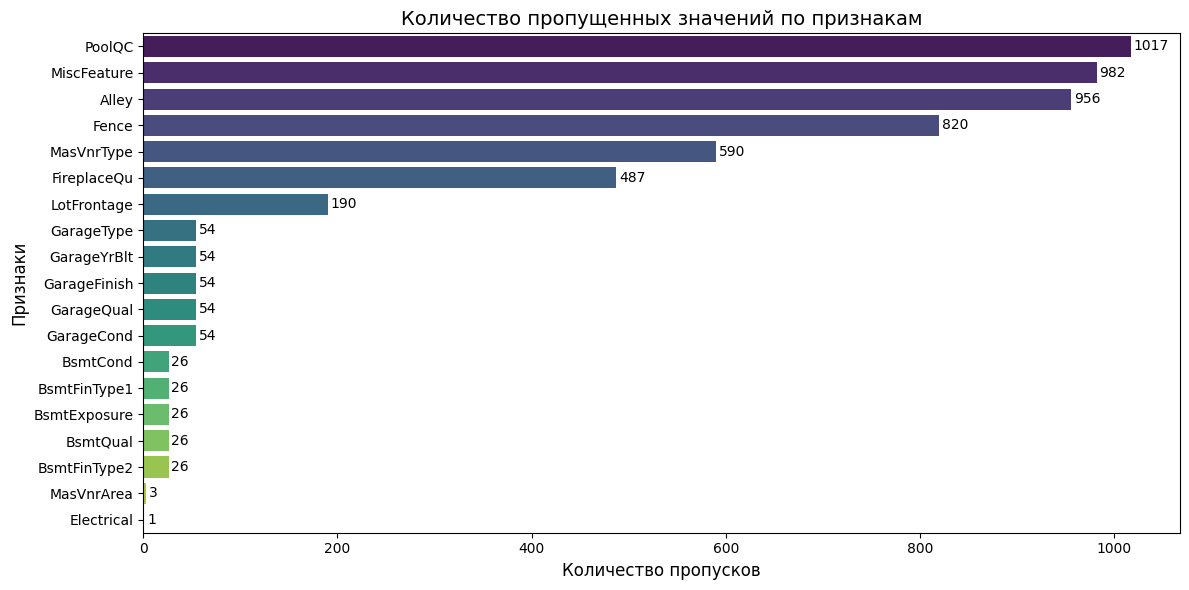

In [145]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_missing_values(df):
    # Считаем количество пропусков в каждом столбце
    missing = df.isnull().sum()
    missing = missing[missing > 0]  # Берем только столбцы с пропусками
    missing.sort_values(inplace=True, ascending=False)
    
    # Настраиваем график
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=missing.values, y=missing.index, palette='viridis')
    
    # Добавляем подписи
    plt.title('Количество пропущенных значений по признакам', fontsize=14)
    plt.xlabel('Количество пропусков', fontsize=12)
    plt.ylabel('Признаки', fontsize=12)
    
    # Добавляем аннотации
    for p in ax.patches:
        width = p.get_width()
        plt.text(width + 3, 
                 p.get_y() + p.get_height()/2, 
                 f'{int(width)}', 
                 ha='left', 
                 va='center')
    
    plt.tight_layout()
    plt.show()

# Использование
plot_missing_values(X_train)

In [146]:
def remove_outliers_mahalanobis(df):
    # Только числовые признаки
    df_numeric = df.select_dtypes(include=[np.number])

    # Замена NaN на строку "missing"
    df_numeric = df_numeric.fillna("missing")

    # Замена бесконечные значения на строку "infinite"
    df_numeric.replace([np.inf, -np.inf], "infinite", inplace=True)

    # Преобразование в строковый тип
    df_numeric = df_numeric.astype(str)

    # Расчет Махалонобиса
    df_numeric = df_numeric.apply(pd.to_numeric, errors='coerce')

    # Заполнение NaN после преобразования строк обратно в числа
    df_numeric = df_numeric.fillna(df_numeric.median())

    # Среднее и ковариационная матрица
    mean = df_numeric.mean(axis=0)
    cov_matrix = np.cov(df_numeric, rowvar=False)
    
    # Проверка на сингулярность ковариационной матрицы
    if np.linalg.det(cov_matrix) == 0:
        raise ValueError("Ковариационная матрица сингулярна и не может быть инвертирована.")
    
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    
    # Вычисление расстояний Махалонобиса для каждого наблюдения
    distances = []
    for index, row in df_numeric.iterrows():
        dist = mahalanobis(row, mean, inv_cov_matrix)
        distances.append(dist)
    
    distances = np.array(distances)
    
    threshold = 3
    non_outliers = df[distances < threshold]
    return non_outliers

X_train_no_outliers = remove_outliers_mahalanobis(X_train)


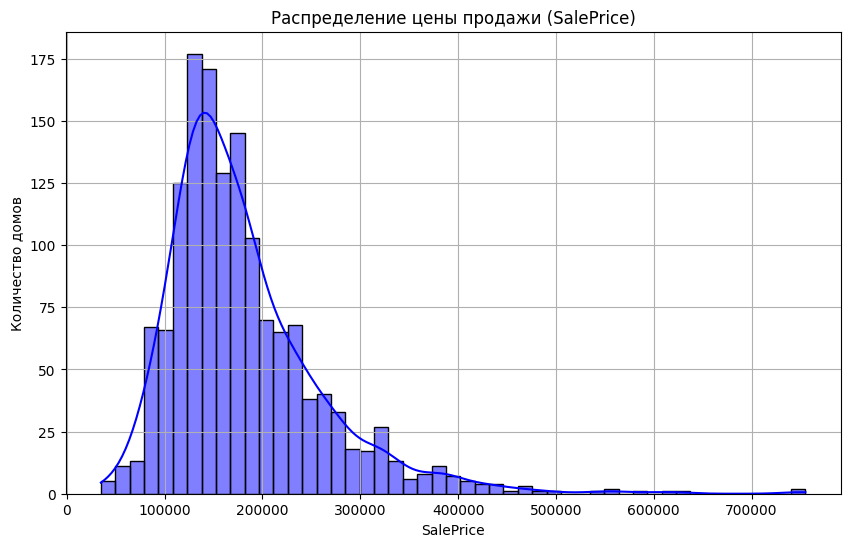

In [147]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.histplot(df_train['SalePrice'], kde=True, color='blue')
plt.title('Распределение цены продажи (SalePrice)')
plt.xlabel('SalePrice')
plt.ylabel('Количество домов')
plt.grid(True)
plt.show()


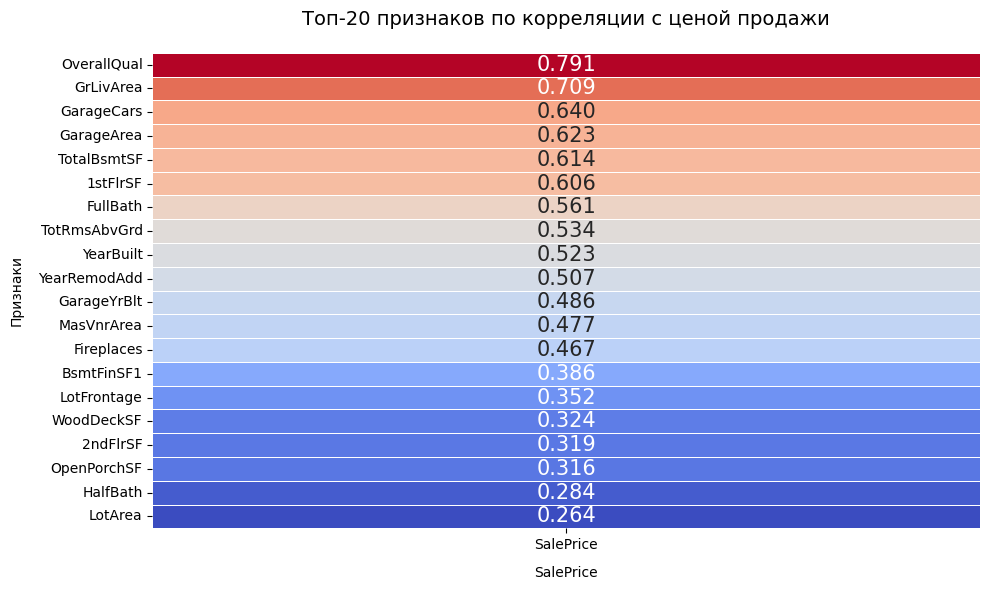

In [159]:
# Корреляция только с числовыми признаками
corr = df_train.select_dtypes(include=['int64', 'float64']).corr(numeric_only=True)

top20_corr = corr['SalePrice'].abs().sort_values(ascending=False).head(21).index[1:]  # Без SalePrice

plt.figure(figsize=(10, 6))
sns.heatmap(corr.loc[top20_corr, ['SalePrice']].sort_values(by='SalePrice', ascending=False),
            annot=True, 
            cmap='coolwarm',
            fmt='.3f',
            cbar=False,
            linewidths=0.5,
            annot_kws={'size': 15})

plt.title('Топ-20 признаков по корреляции с ценой продажи', pad=20, fontsize=14)
plt.xlabel('SalePrice', labelpad=10)
plt.ylabel('Признаки', labelpad=10)
plt.xticks(rotation=0)
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

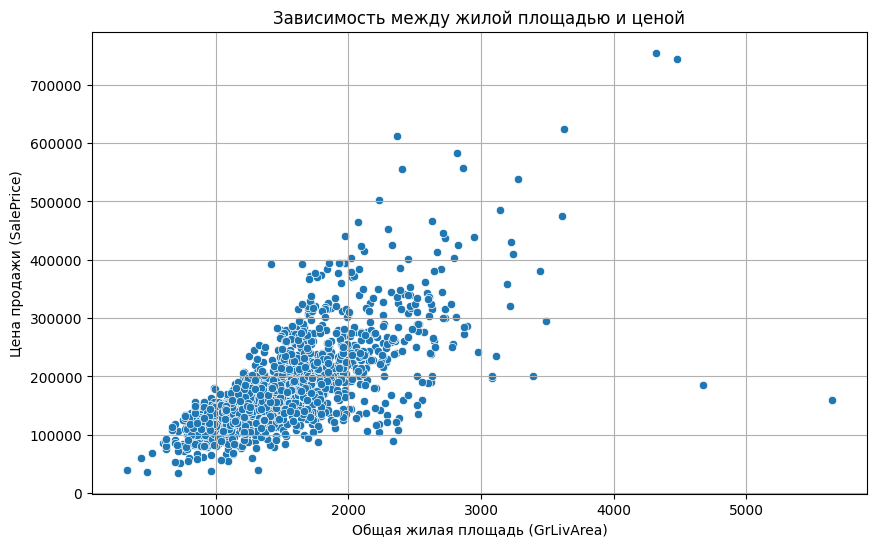

In [149]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='GrLivArea', y='SalePrice', data=df_train)
plt.title('Зависимость между жилой площадью и ценой')
plt.xlabel('Общая жилая площадь (GrLivArea)')
plt.ylabel('Цена продажи (SalePrice)')
plt.grid(True)
plt.show()


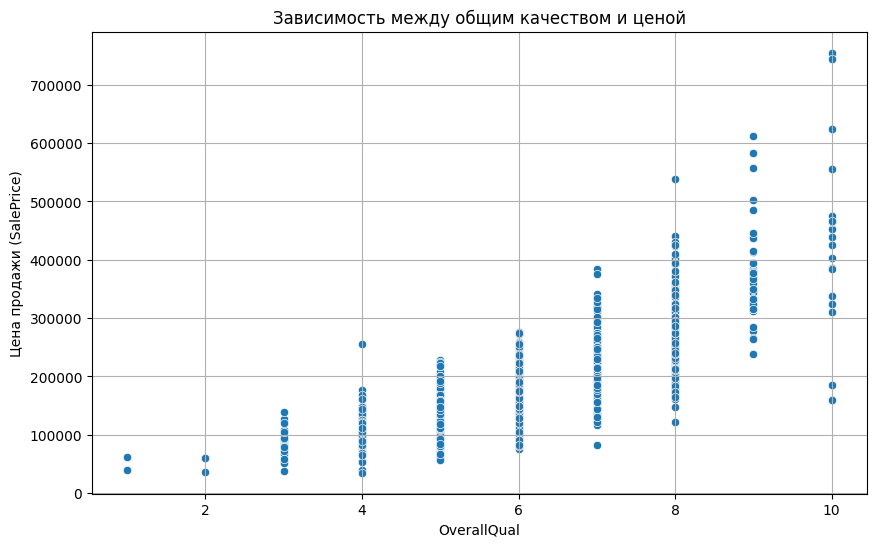

In [150]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='OverallQual', y='SalePrice', data=df_train)
plt.title('Зависимость между общим качеством и ценой')
plt.xlabel('OverallQual')
plt.ylabel('Цена продажи (SalePrice)')
plt.grid(True)
plt.show()


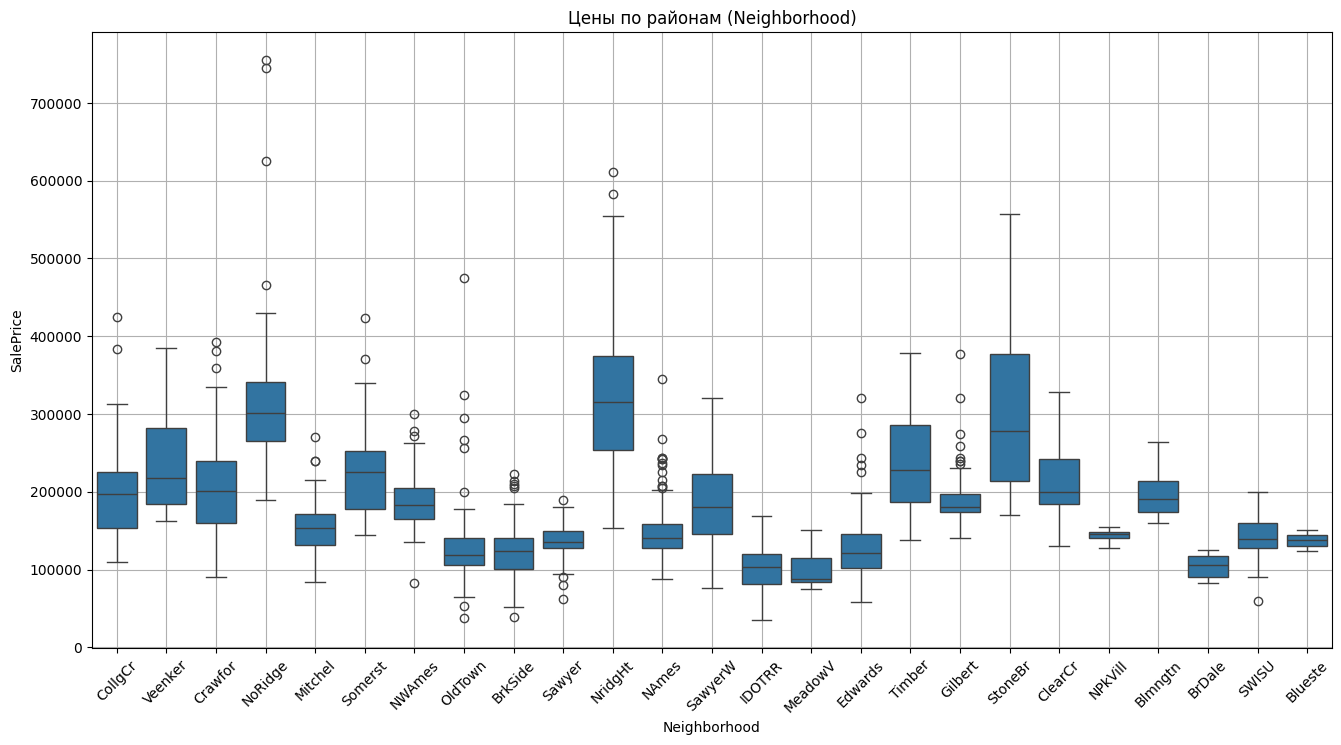

In [151]:
plt.figure(figsize=(16,8))
sns.boxplot(x='Neighborhood', y='SalePrice', data=df_train)
plt.title('Цены по районам (Neighborhood)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [152]:
def add_features(df):
    df = df.copy()
    df['HouseAge']      = df['YrSold'] - df['YearBuilt']
    df['SinceRemodel']  = df['YrSold'] - df['YearRemodAdd']
    df['TotalBath']     = (df['FullBath'] + 0.5 * df['HalfBath'] + 
                           df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath'])
    df['HasPool']       = (df['PoolArea'] > 0).astype(int)
    df['TotalPorch']    = (df['OpenPorchSF'] + df['EnclosedPorch'] +
                           df['3SsnPorch'] + df['ScreenPorch'])
    return df

feature_engineering = FunctionTransformer(add_features)

In [153]:
# Препроцессинг Pipelines

# Числовые: заполнить медианой
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

# Категориальные: заполнить "No" и OHE
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='No')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

In [154]:
# Сборка Pipeline модели
pipeline = Pipeline(steps=[
    ('features', feature_engineering),
    ('preproc', preprocessor),
    ('model', CatBoostRegressor(
        verbose=0,
        random_seed=42,
        loss_function='RMSE',
        early_stopping_rounds=50
    ))
])

In [155]:
# Тюнинг гиперпараметров (GridSearch)
param_grid = {
    'model__iterations': [500, 1000],
    'model__learning_rate': [0.03, 0.05, 0.1],
    'model__depth': [4, 6]
}
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
print("Best params:", grid_search.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'model__depth': 6, 'model__iterations': 1000, 'model__learning_rate': 0.05}


In [156]:
from sklearn.metrics import mean_squared_log_error

# Оценка на валидации
best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(X_val)

# RMSE
mse = mean_squared_error(y_val, y_val_pred)
val_rmse = np.sqrt(mse)
print(f"Validation RMSE: {val_rmse:.4f}")

# Проверка на отрицательные значения
assert (y_val_pred >= 0).all(), "Предсказания содержат отрицательные значения"
assert (y_val >= 0).all(), "Фактические значения содержат отрицательные числа"

# RMSLE
val_rmsle = np.sqrt(mean_squared_log_error(y_val, y_val_pred))
print(f"Validation RMSLE: {val_rmsle:.4f}")

Validation RMSE: 22479.4389
Validation RMSLE: 0.1225


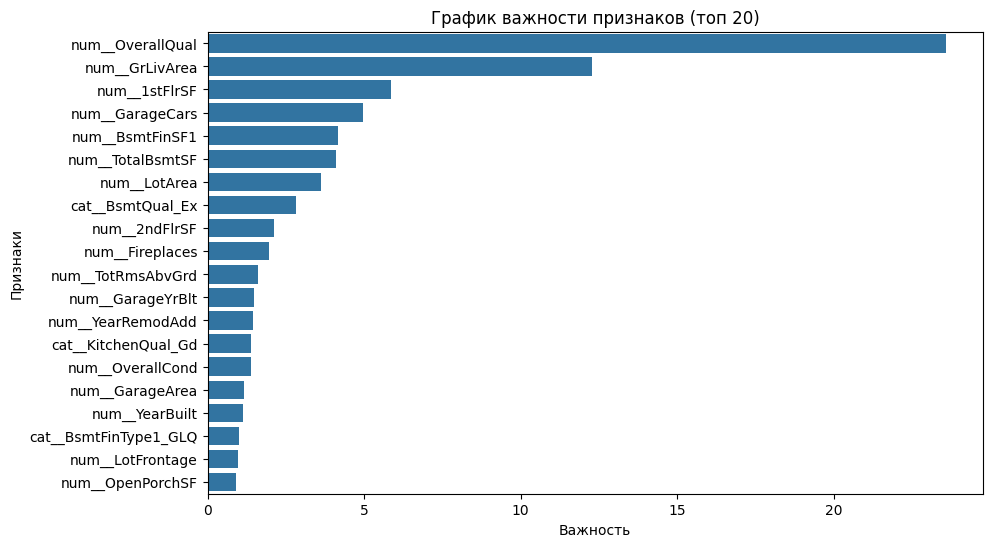

In [157]:
importances = best_model.named_steps['model'].get_feature_importance()

feature_names = best_model.named_steps['preproc'].get_feature_names_out()

sorted_idx = np.argsort(importances)[::-1][:20]
sorted_importances = importances[sorted_idx]
sorted_feature_names = feature_names[sorted_idx]

plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_importances, y=sorted_feature_names)
plt.title('График важности признаков (топ 20)')
plt.xlabel('Важность')
plt.ylabel('Признаки')
plt.show()

In [158]:

# Предсказание на тесте
y_test_pred = best_model.predict(X_test)
submission = pd.DataFrame({
    'Id': df_test['Id'],
    'SalePrice': y_test_pred
})
submission.to_csv('submission.csv', index=False)